In [1]:
import spatialdata as sd
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from spatialdata import get_extent
from spatialdata import bounding_box_query
from spatialdata import match_element_to_table
import spatialdata_plot
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from datatree import DataTree
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
from sklearn.neighbors import KernelDensity
from easydecon.easydecon import *
from easydecon.config import *
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent



pd.set_option('display.max_rows', 500)

In [2]:
# load a compatible color map for the spatial data
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

Now we load the spatial data and the target data. We use 8um bin size which is an acceptable resolution. Set the sample id and point spaceranger output directory.

In [3]:
bin_size=8
sample_id="sampleP2"

sdata=spatialdata_io.visium_hd("../../sampleP2/binned_outputs/",fullres_image_file="../../sampleP2/Visium_HD_Human_Colon_Cancer_tissue_image.btf",
                               bin_size=bin_size,dataset_id=sample_id,load_all_images=True)
sdata

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'sampleP2_cytassist_image': DataArray[cyx] (3, 3000, 3200)
│     ├── 'sampleP2_full_image': DataTree[cyx] (3, 48740, 75250), (3, 24370, 37625), (3, 12185, 18812), (3, 6092, 9406), (3, 3046, 4703)
│     ├── 'sampleP2_hires_image': DataArray[cyx] (3, 3886, 6000)
│     └── 'sampleP2_lowres_image': DataArray[cyx] (3, 389, 600)
├── Shapes
│     └── 'sampleP2_square_008um': GeoDataFrame shape: (545913, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (545913, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        sampleP2_hires_image (Images), sampleP2_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        sampleP2_lowres_image (Images), sampleP2_square_008um (Shapes)
    ▸ 'global', with elements:
        sampleP2_cytassist_image (Images), sampleP2_full_image (Images), sampleP2_square_008um (Shapes)

In [4]:
# to align the high resolution image with the spatial data, we need to run this part
data_extent=get_extent(sdata[f"{sample_id}_square_00{bin_size}um"])

queried_cytassist = bounding_box_query(
    sdata[f"{sample_id}_full_image"],
    min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
    max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"),
    target_coordinate_system="global",
)

sdata["queried_cytassist"]=queried_cytassist

We need to normalize the data before running the spatial deconvolution. We will use the normalization method from scanpy. We can also add the qc metrics.

In [5]:
for table in sdata.tables.values():
   table.var_names_make_unique()
   sc.pp.calculate_qc_metrics(table, inplace=True)
   sc.pp.filter_genes(table, min_cells=3)
   sc.pp.filter_cells(table, min_counts=1)
   sc.pp.normalize_total(table, inplace=True,target_sum=1e4)
   sc.pp.log1p(table)
   #sc.pp.scale(table)
   #sc.pp.pca(table)
   #sc.pp.neighbors(table)
   #sc.tl.umap(table)

#here we filter the spatial data to only include the cells that are in the table
sdata.shapes[f"{sample_id}_square_00{bin_size}um"]=sdata.shapes[f"{sample_id}_square_00{bin_size}um"][sdata.shapes[f"{sample_id}_square_00{bin_size}um"].index.isin(sdata.tables[f"square_00{bin_size}um"].obs["location_id"])]

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `sampleP2_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


We can run Easydecon on the subregion of the data. We also also use the entire section to run the spatial deconvolution but it is faster to run on the region of interest.
Lets select a subregion. You can check the coordinates of the region of interest from the image above.

In [6]:
sdata_small = sdata.query.bounding_box(
   min_coordinate=[42000, 12000], max_coordinate=[50000, 18000], axes=("x", "y"), target_coordinate_system="global"
)

In [7]:
common_macrophage_markers = ["CD14","CD68","CD163","HLA-DRB1","HLA-DQA1","HLA-DPA1","S100A8","S100A9","S100A12","MCEMP1","AQP9","IL1B","CXCL8","CCL3","CCL4","HILPDA","HIF1A-AS3","CXCL10","GBP1","CXCL9","IDO1","SPP1","APOC1","ACP5","APOE","CCL19","CD207","CD1A","CD1E","DNASE1L3","C1QA","C1QC","MRC1","SELENOP","FOLR2","F13A1","LYVE1","FCER1A","CCL17","CCL22","CD1C","TOP2A","MKI67"]
gene_expression=common_markers_gene_expression_and_filter(sdata_small, common_macrophage_markers, common_group_name= "Macrophage",bin_size=8,quantile=0.7)

INFO     Using matplotlib                                                                                          


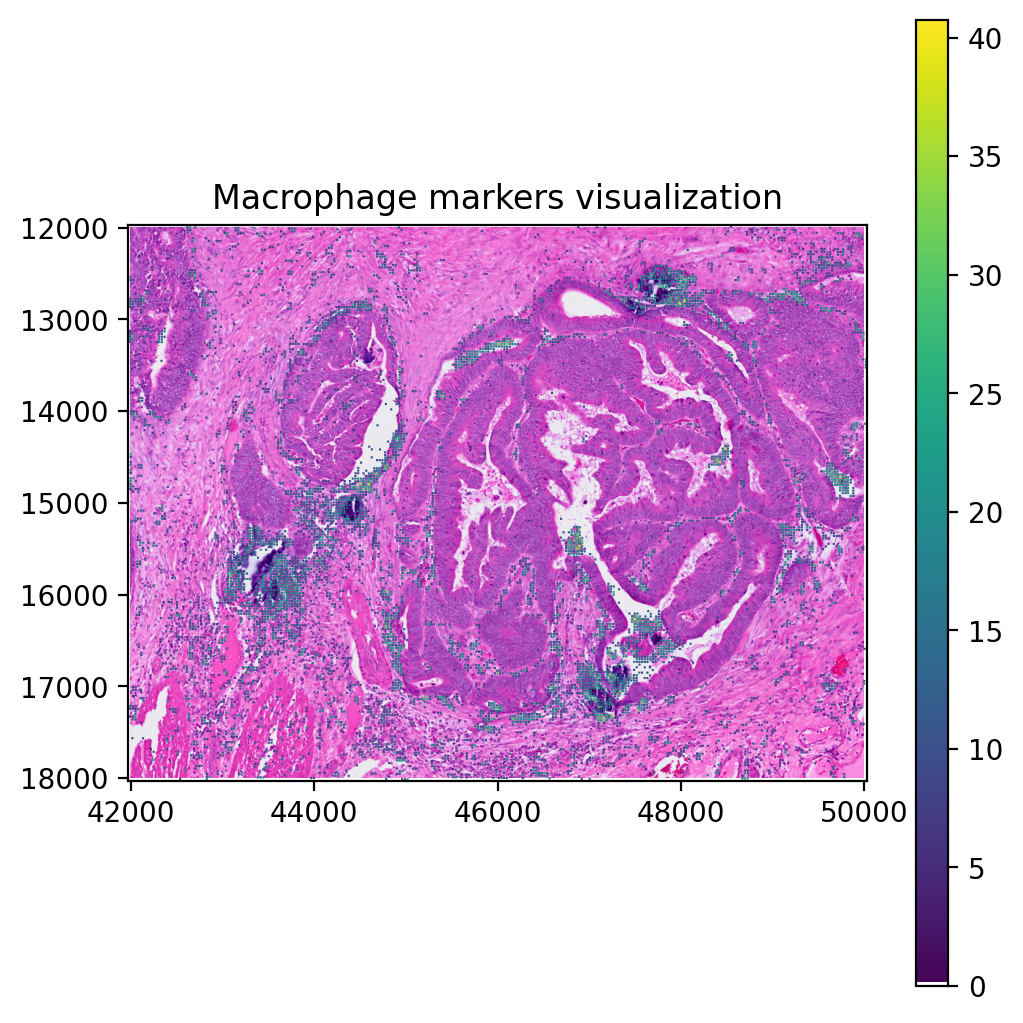

In [8]:
sdata_small.pl.render_images("queried_cytassist").pl.render_shapes(
        f"{sample_id}_square_00{bin_size}um", color="Macrophage",cmap=new_cmap,method="matplotlib",scale=0.8
    ).pl.show(coordinate_systems="global", title="Macrophage markers visualization", legend_fontsize=8,figsize=(5,5),dpi=200)

In [9]:
macro_clusters_dict= {"Cluster 0": ["IL1B", "CXCL8", "CCL3", "CCL4", "APOE", "C1QA", "C1QC", "MRC1", "SELENOP", "FOLR2", "F13A1", "LYVE1"],
"Cluster 1": ["S100A8", "S100A9", "CXCL8", "CCL3", "CCL4", "SPP1", "APOC1", "ACP5", "APOE", "C1QA", "C1QC", "MRC1"],
"Cluster 2": ["IL1B", "CXCL8", "CCL3", "CCL4", "APOC1", "ACP5", "APOE", "DNASE1L3", "C1QA", "C1QC", "MRC1", "SELENOP"],
"Cluster 3": ["S100A8", "S100A9", "IL1B"],
"Cluster 4": ["S100A8", "S100A9", "AQP9", "IL1B", "CXCL8", "CCL3", "CCL4"],
"Cluster 5": ["S100A8", "S100A9", "AQP9", "IL1B", "CXCL8", "CCL3", "CCL4", "HILPDA", "HIF1A-AS3"],
"Cluster 6": ["APOC1", "ACP5", "APOE", "C1QA", "C1QC"],
"Cluster 7": ["IL1B", "CXCL8", "CCL3", "CCL4", "ACP5", "APOE", "DNASE1L3", "C1QA", "C1QC", "MRC1", "SELENOP", "FOLR2", "F13A1"],
"Cluster 8": ["S100A8", "S100A9", "AQP9", "IL1B", "CXCL8", "CCL3", "CCL4", "CXCL10", "GBP1", "CXCL9", "IDO1", "ACP5", "C1QA", "C1QC", "MRC1"],
"Cluster 9": ["IL1B", "CXCL8", "CCL3", "CCL4", "C1QA", "C1QC", "MRC1", "FCER1A", "CD1C"],
"Cluster 10": ["SPP1", "APOC1", "ACP5", "APOE", "C1QA", "C1QC", "MRC1", "SELENOP", "FOLR2", "F13A1", "TOP2A", "MKI67"]}

macro_df = pd.DataFrame(list(macro_clusters_dict.items()), columns=['Cluster', 'names']).explode('names').reset_index(drop=True)
macro_df.set_index('Cluster', inplace=True)

In [10]:
df_cluster_overlap_macro=get_clusters_by_similarity_on_tissue(sdata_small,markers_df=macro_df,common_group_name="Macrophage",method="overlap")

Method: Overlap


100%|██████████| 6886/6886 [00:08<00:00, 779.15it/s]
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/joblib/externals/loky/process_execu

In [11]:
sdata_small.tables[f"square_00{bin_size}um"].obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'location_id', 'region',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'n_counts', 'Macrophage', 'Cluster 0',
       'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5',
       'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10'],
      dtype='object')

INFO     Using matplotlib                                                                                          


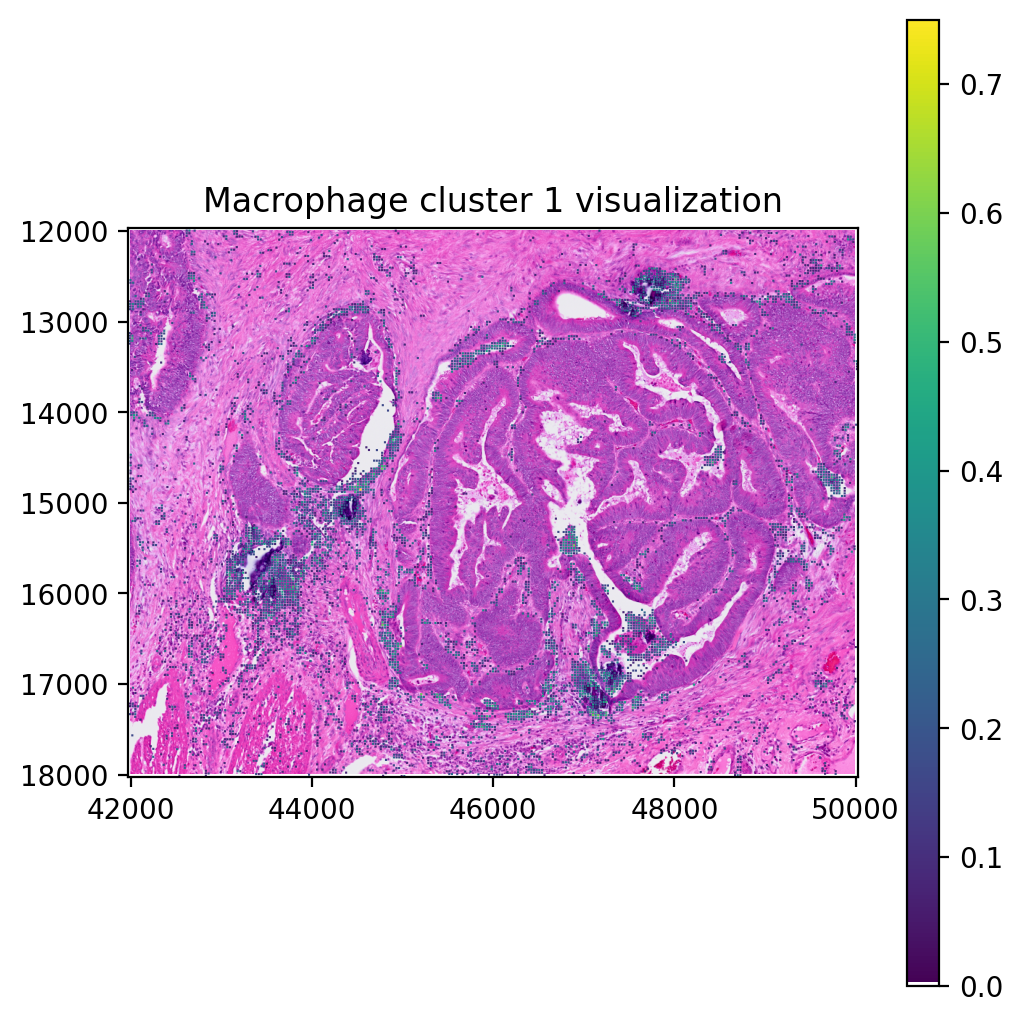

In [12]:
sdata_small.pl.render_images("queried_cytassist").pl.render_shapes(
        f"{sample_id}_square_00{bin_size}um", color="Cluster 1",cmap=new_cmap,method="matplotlib",scale=0.8
    ).pl.show(coordinate_systems="global", title="Macrophage cluster 1 visualization", legend_fontsize=8,figsize=(5,5),dpi=200)

In [17]:
sdata_small.tables[f"square_00{bin_size}um"].obs["overlapmacrophage"].value_counts()

overlapmacrophage
Cluster 6     5027
Cluster 0      444
Cluster 3      419
Cluster 10     396
Cluster 1      240
Cluster 8      103
Cluster 9       99
Cluster 4       60
Cluster 5       29
Cluster 2       25
Cluster 7        3
Name: count, dtype: int64

INFO     Using matplotlib                                                                                          


/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:719: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


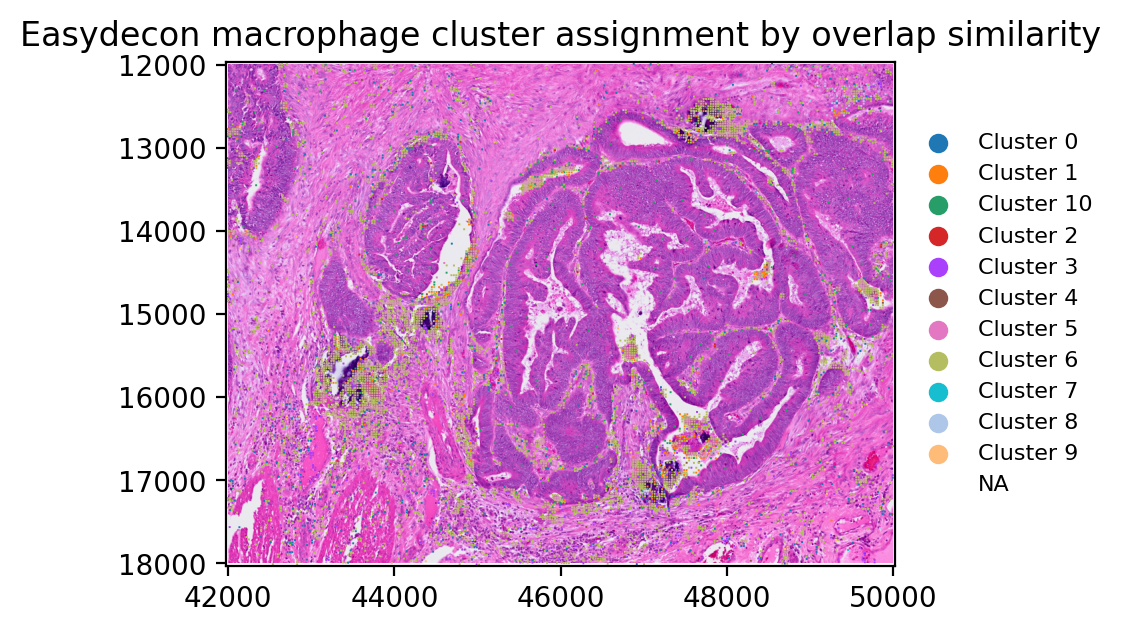

In [18]:
assign_clusters_from_df(sdata_small,df=df_cluster_overlap_macro,bin_size=8,results_column="overlapmacrophage")


sdata_small.pl.render_images("queried_cytassist").pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="overlapmacrophage",method="matplotlib",scale=0.8,na_color= (0.0, 0.0, 0.0, 0.0)
        ).pl.show(coordinate_systems="global", title="Easydecon macrophage cluster assignment by overlap similarity", legend_fontsize=8,figsize=(5,5),dpi=200)
